In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import Xception 
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [2]:
image_path = '/kaggle/input/flickr8kimagescaptions/flickr8k/images'

In [3]:
data = pd.read_csv("/kaggle/input/flickr8kimagescaptions/flickr8k/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [4]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/kaggle/input/flickr8kimagescaptions/flickr8k/images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

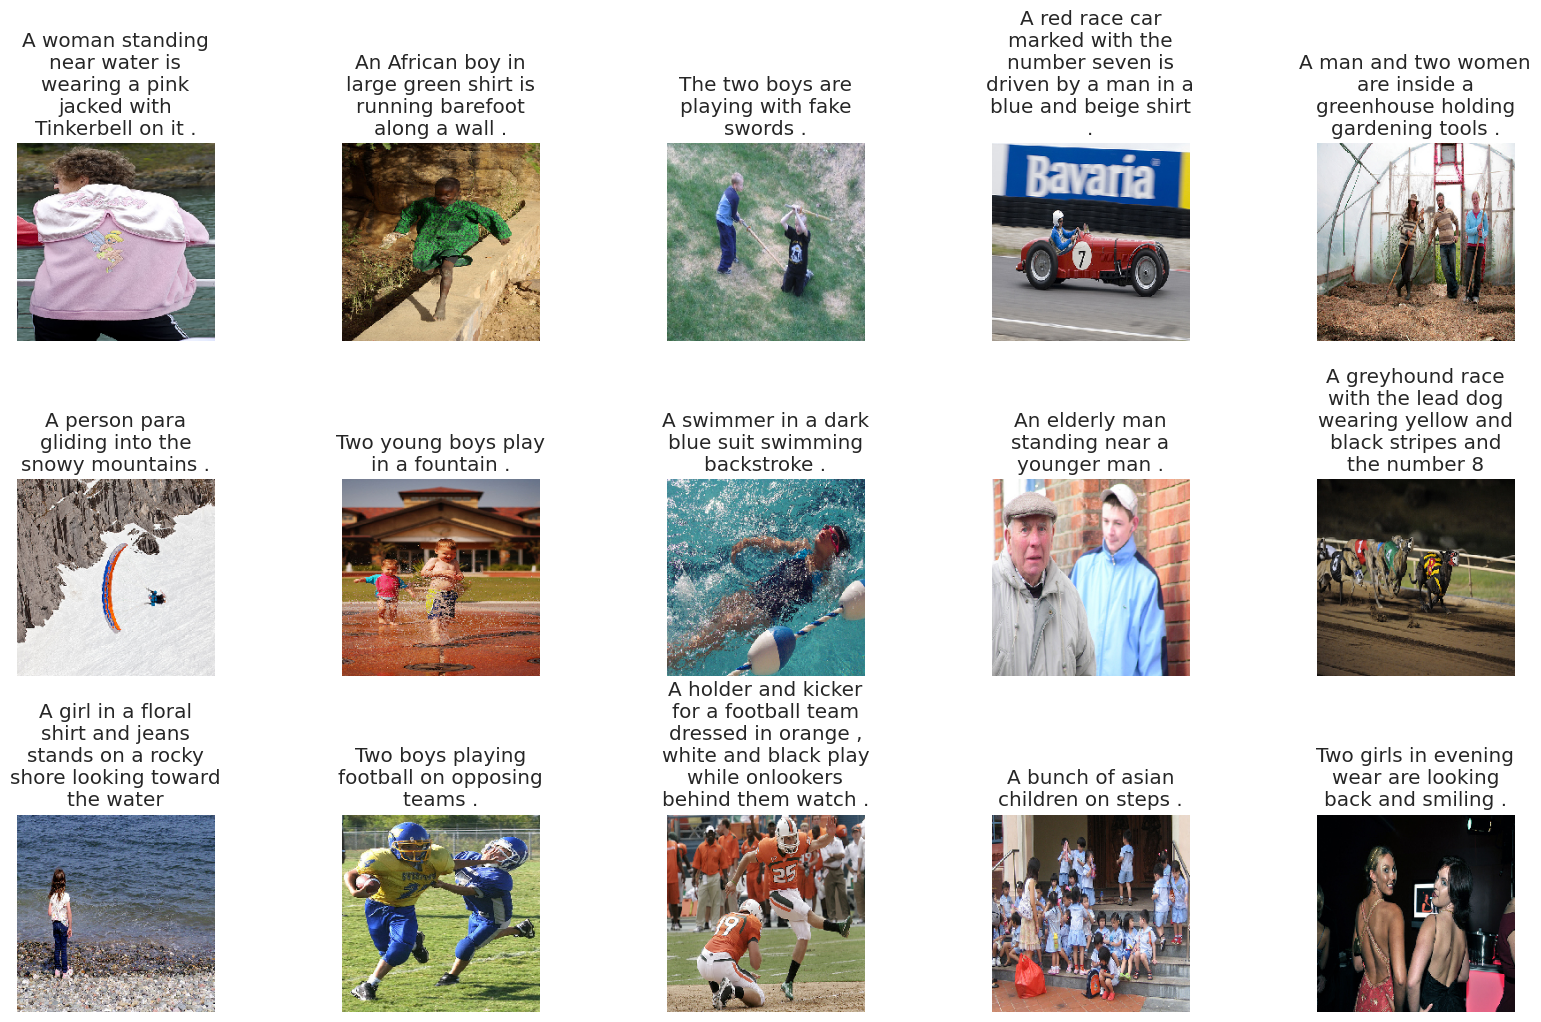

In [5]:
display_images(data.sample(15))


In [6]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [7]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [11]:
model = Xception(include_top=False, pooling='avg')  # Changed from DenseNet201 to Xception
fe = model

img_size = 299  # Changed from 224 to 299 for Xception
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature
    
# model = DenseNet201()
# fe = Model(inputs=model.input, outputs=model.layers[-2].output)

# img_size = 224
# features = {}
# for image in tqdm(data['image'].unique().tolist()):
#     img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
#     img = img_to_array(img)
#     img = img/255.
#     img = np.expand_dims(img,axis=0)
#     feature = fe.predict(img, verbose=0)
#     features[image] = feature

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


100%|██████████| 8091/8091 [09:08<00:00, 14.75it/s]


In [9]:
# Load InceptionV3 model
inception_model = InceptionV3(include_top=False, pooling='avg')
fe = inception_model
img_size = 299  # InceptionV3 requires 299x299 input

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [10]:
# Extract features from all images
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    # Preprocess the image for InceptionV3
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 8091/8091 [10:22<00:00, 13.00it/s]


In [11]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [ ]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [14]:
# Changed input shape from 1920 to 2048 for Xception output
input1 = Input(shape=(2048,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model1 = Model(inputs=[input1, input2], outputs=output)
caption_model1.compile(loss='categorical_crossentropy', optimizer='adam')

In [12]:
# Build the model with InceptionV3 feature size (2048)
input1 = Input(shape=(2048,))  # InceptionV3 outputs 2048 features
input2 = Input(shape=(max_length,))

# Image feature processing branch
img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

# Text processing branch
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)

# Merge image and text features
merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model2 = Model(inputs=[input1, input2], outputs=output)
caption_model2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001))

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(caption_model)

In [ ]:
caption_model.summary()

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(caption_model1)

caption_model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │        524,544 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 34)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 256)         │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 34, 256)        │      2,172,160 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 35, 256)        │              0 │ reshape_1[0][0],       │
│ (Concatenate)             │                        │                │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 256)            │        525,312 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_13 (Add)              │ (None, 256)            │              0 │ dropout_2[0][0],       │
│                           │                        │                │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         32,896 │ add_13[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 8485)           │      1,094,565 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,349,477 (16.59 MB)

 Trainable params: 4,349,477 (16.59 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(caption_model2)

caption_model2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 34)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 256)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 34, 256)        │      2,172,160 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 35, 256)        │              0 │ reshape[0][0],         │
│ (Concatenate)             │                        │                │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dropout[0][0],         │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8485)           │      1,094,565 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,349,477 (16.59 MB)

 Trainable params: 4,349,477 (16.59 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [17]:
model_name = "xception_model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only=True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [15]:
# Setup callbacks
model_name = "inception_model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only=True,
                            verbose=1)

earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    restore_best_weights=True
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    factor=0.2,
    min_lr=0.00000001
)



In [ ]:
history = caption_model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

In [19]:
history = caption_model1.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/10
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 3.2871
Epoch 1: val_loss did not improve from 3.63805
537/537 ━━━━━━━━━━━━━━━━━━━━ 79s 146ms/step - loss: 3.2872 - val_loss: 3.6449 - learning_rate: 0.0010
Epoch 2/10
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 3.2500
Epoch 2: val_loss did not improve from 3.63805
537/537 ━━━━━━━━━━━━━━━━━━━━ 73s 135ms/step - loss: 3.2500 - val_loss: 3.6707 - learning_rate: 0.0010
Epoch 3/10
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 3.2050
Epoch 3: val_loss did not improve from 3.63805
537/537 ━━━━━━━━━━━━━━━━━━━━ 78s 143ms/step - loss: 3.2051 - val_loss: 3.6830 - learning_rate: 0.0010
Epoch 4/10
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 3.1729
Epoch 4: val_loss did not improve from 3.63805

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
537/537 ━━━━━━━━━━━━━━━━━━━━ 77s 142ms/step - loss: 3.1729 - val_loss: 3.7253 - learning_rate: 0.0010
Epoch 5/10
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/s

In [17]:
# Train the model
history = caption_model2.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]
)



Epoch 1/10
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 3.6876
Epoch 1: val_loss did not improve from 3.84216
537/537 ━━━━━━━━━━━━━━━━━━━━ 79s 145ms/step - loss: 3.6876 - val_loss: 3.8437 - learning_rate: 0.0010
Epoch 2/10
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 3.6599
Epoch 2: val_loss did not improve from 3.84216
537/537 ━━━━━━━━━━━━━━━━━━━━ 78s 143ms/step - loss: 3.6600 - val_loss: 3.8561 - learning_rate: 0.0010
Epoch 3/10
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 3.6103
Epoch 3: val_loss did not improve from 3.84216
537/537 ━━━━━━━━━━━━━━━━━━━━ 76s 140ms/step - loss: 3.6104 - val_loss: 3.8505 - learning_rate: 0.0010
Epoch 4/10
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 3.5881
Epoch 4: val_loss did not improve from 3.84216

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
537/537 ━━━━━━━━━━━━━━━━━━━━ 77s 141ms/step - loss: 3.5882 - val_loss: 3.8586 - learning_rate: 0.0010
Epoch 5/10
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/s

In [18]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [19]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [20]:
with open(os.path.join('/kaggle/input/flickr8kimagescaptions/flickr8k', 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()


In [21]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 570865.94it/s]


In [22]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [27]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    # Load the image
    img_path = os.path.join(image_path, image_name)  # Using the image_path from your original code
    image = Image.open(img_path)
    
    # Get all captions for this image from the DataFrame
    image_captions = data[data['image'] == image_name]['caption'].tolist()
    
    print('---------------------Actual---------------------')
    for caption in image_captions:
        # Clean up the caption for display
        clean_caption = caption.replace("startseq ", "").replace(" endseq", "")
        print(clean_caption)
    
    # Predict the caption
    y_pred = predict_caption(caption_model1, image_name, tokenizer, max_length, features)
    
    print('--------------------Predicted--------------------')
    # Clean up the predicted caption
    y_pred_clean = y_pred.replace("startseq ", "").replace(" endseq", "")
    print(y_pred_clean)
    
    # Display the image
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


In [23]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    # Load the image
    img_path = os.path.join(image_path, image_name)  # Using the image_path from your original code
    image = Image.open(img_path)
    
    # Get all captions for this image from the DataFrame
    image_captions = data[data['image'] == image_name]['caption'].tolist()
    
    print('---------------------Actual---------------------')
    for caption in image_captions:
        # Clean up the caption for display
        clean_caption = caption.replace("startseq ", "").replace(" endseq", "")
        print(clean_caption)
    
    # Predict the caption
    y_pred = predict_caption(caption_model2, image_name, tokenizer, max_length, features)
    
    print('--------------------Predicted--------------------')
    # Clean up the predicted caption
    y_pred_clean = y_pred.replace("startseq ", "").replace(" endseq", "")
    print(y_pred_clean)
    
    # Display the image
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


---------------------Actual---------------------
little girl covered in paint sits in front of painted rainbow with her hands in bowl
little girl is sitting in front of large painted rainbow
small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it
there is girl with pigtails sitting in front of rainbow painting
young girl with pigtails painting outside in the grass
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
--------------------Predicted--------------------
man in red shirt is standing on the street


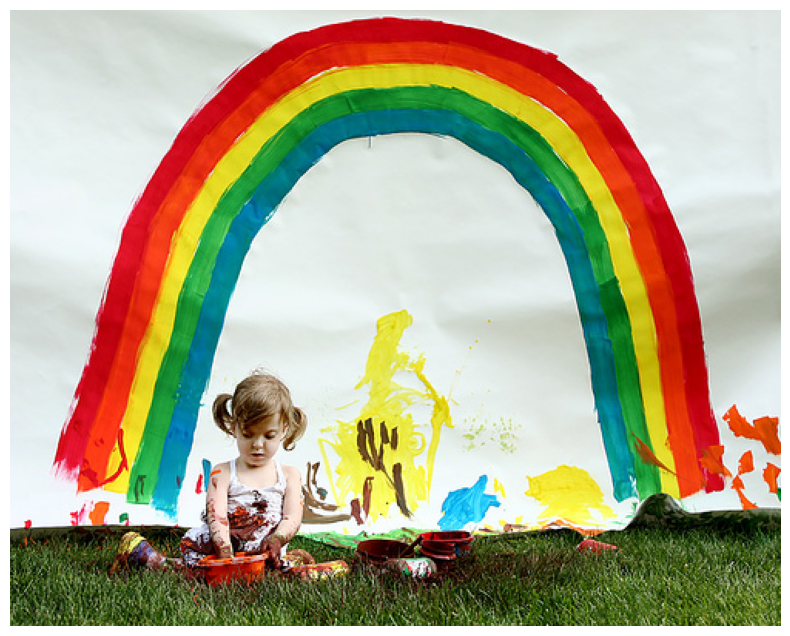

In [24]:
generate_caption("1002674143_1b742ab4b8.jpg")